World Coins: A collection of coin images from 32 different currencies.

In [66]:
# Seznam knihoven
import os
import numpy as np
import random
import cv2
import kaggle
import concurrent.futures
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from pathlib import Path
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [67]:
# Sta≈æen√≠ dat z Kaggle p≈ôes API token
kaggle.api.dataset_download_files('wanderdust/coin-images', path='./data', unzip=True)
print("Dataset byl √∫spƒõ≈°nƒõ sta≈æen a rozbalen do slo≈æky ./data!")

Dataset URL: https://www.kaggle.com/datasets/wanderdust/coin-images
Dataset byl √∫spƒõ≈°nƒõ sta≈æen a rozbalen do slo≈æky ./data!


In [68]:
# Napojen√≠ dat a vytvo≈ôen√≠ cesty
data_dir_train = "data/coins/data/train/"
data_dir_val = "data/coins/data/validation/"
data_dir_test = "data/coins/data/test/"
outlier_dir = "data/coins/data/outliers"
json_path = "data/cat_to_name.json"

O≈ôez√°n√≠ prav√©ho okraje obr√°zku o 8 % pro odstranƒõn√≠ vodoznaku

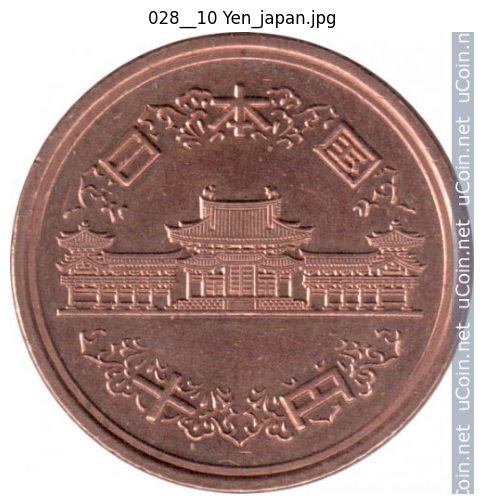

In [70]:
def get_random_image(directory):
    all_folders = [os.path.join(directory, folder) for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    random_folder = random.choice(all_folders)
    all_images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.choice(all_images)
random_image_path = get_random_image(data_dir_train)
if random_image_path:
    img = Image.open(random_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{os.path.basename(random_image_path)}")
    plt.show()

In [71]:
def crop_images_in_directory(directory, crop_percentage=0.08):
    """ O≈ô√≠zne prav√Ω okraj v≈°ech obr√°zk≈Ø v dan√©m adres√°≈ôi a jeho podslo≈æk√°ch. """
    directory = Path(directory)

    for file_path in directory.rglob('*.[jp][pn]g'):  # Hled√° soubory s p≈ô√≠ponami .jpg, .jpeg, .png
        with Image.open(file_path) as img:
            new_width = int(img.width * (1 - crop_percentage))
            img.crop((0, 0, new_width, img.height)).save(file_path)  # O≈ô√≠zne a ulo≈æ√≠ zpƒõt
            print(f"O≈ôez√°no: {file_path}")  # Debug informace

# Spu≈°tƒõn√≠ pro test a validation
crop_images_in_directory(data_dir_train)
crop_images_in_directory(data_dir_val)

print("V≈°echny obr√°zky byly √∫spƒõ≈°nƒõ o≈ô√≠znuty.")

O≈ôez√°no: data\coins\data\train\1\001__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\002__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\004__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\005__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\007__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\008__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\009__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\010__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\011__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\012__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\014__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\015__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\016__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\017__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\018__1 Cent_australia.jpg
O≈ôez√°no: data\coins\data\train\1\019__1 Cent_australia.jpg
O≈ôez√°no: data\coins\da

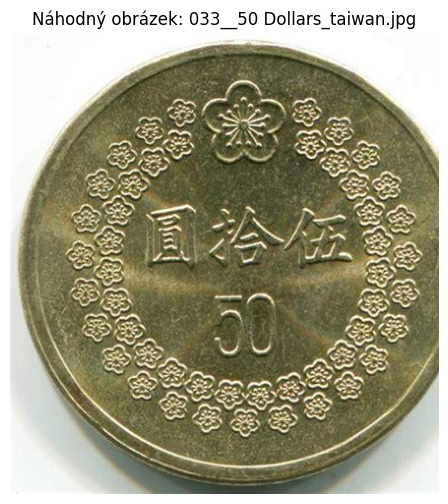

In [72]:
def get_random_image(directory):
    all_folders = [os.path.join(directory, folder) for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    random_folder = random.choice(all_folders)
    all_images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.choice(all_images)
random_image_path = get_random_image(data_dir_train)
if random_image_path:
    img = Image.open(random_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"N√°hodn√Ω obr√°zek: {os.path.basename(random_image_path)}")
    plt.show()

Odstranƒõn√≠ pozad√≠ obr√°zku

In [73]:
# Cesty ke slo≈æk√°m s tr√©novac√≠mi a validaƒçn√≠mi daty
data_dirs = ["data/coins/data/train/", "data/coins/data/validation/"]

# Funkce pro generov√°n√≠ masek
def generate_masks(image_folder):
    """ Pro ka≈æd√Ω obr√°zek v dan√© slo≈æce vytvo≈ô√≠ bin√°rn√≠ masku a ulo≈æ√≠ ji do slo≈æky 'masks/' """
    for folder in sorted(os.listdir(image_folder)):  # Proch√°z√≠me slo≈æky 1‚Äì211
        folder_path = os.path.join(image_folder, folder)

        if os.path.isdir(folder_path):  # Ovƒõ≈ô√≠me, ≈æe jde o slo≈æku
            mask_folder = os.path.join(folder_path, "masks")  # Vytvo≈ô√≠me slo≈æku pro masky
            os.makedirs(mask_folder, exist_ok=True)

            for file in sorted(os.listdir(folder_path)):  # Proch√°z√≠me obr√°zky
                file_path = os.path.join(folder_path, file)

                # Ovƒõ≈ô√≠me, ≈æe soubor je obr√°zek (JPG, PNG)
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    print(f"üé® Generuji masku pro: {file_path}")
                    
                    # Naƒçten√≠ obr√°zku jako grayscale
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"‚ùå Chyba: Nemohu naƒç√≠st {file_path}")
                        continue

                    # Otsu thresholding pro bin√°rn√≠ masku
                    _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

                    # Ulo≈æen√≠ masky do slo≈æky masks/
                    mask_path = os.path.join(mask_folder, file)
                    cv2.imwrite(mask_path, mask)

# Spu≈°tƒõn√≠ generov√°n√≠ masek pro slo≈æky train a validation
for data_dir in data_dirs:
    print(f"üîÑ Generuji masky pro slo≈æku: {data_dir}")
    generate_masks(data_dir)

print("‚úÖ V≈°echny masky byly vygenerov√°ny a ulo≈æeny!")

üîÑ Generuji masky pro slo≈æku: data/coins/data/train/
üé® Generuji masku pro: data/coins/data/train/1\001__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\002__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\004__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\005__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\007__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\008__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\009__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\010__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\011__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\012__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\014__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/train/1\015__1 Cent_australia.jpg
üé® Generuji masku pro: data/coins/data/tra

In [74]:
def build_unet(input_size=(256, 256, 1)):
    """ Vytvo≈ôen√≠ U-Net architektury """
    inputs = Input(input_size)

    # Encoder (doln√≠ ƒç√°st U-Net)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder (horn√≠ ƒç√°st U-Net)
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Vytvo≈ôen√≠ modelu
unet_model = build_unet()

In [75]:
# Velikost obr√°zku pro U-Net
IMAGE_SIZE = (256, 256)

# Funkce pro naƒçten√≠ obr√°zk≈Ø a masek
def load_dataset(data_dirs):
    X, Y = [], []

    for data_dir in data_dirs:
        for folder in sorted(os.listdir(data_dir)):  # Proch√°z√≠me slo≈æky 1‚Äì211
            folder_path = os.path.join(data_dir, folder)

            if os.path.isdir(folder_path):
                mask_folder = os.path.join(folder_path, "masks")  # Slo≈æka s maskami
                
                for file in sorted(os.listdir(folder_path)):  # Proch√°z√≠me obr√°zky
                    file_path = os.path.join(folder_path, file)
                    mask_path = os.path.join(mask_folder, file)

                    # Ovƒõ≈ô√≠me, ≈æe soubor je obr√°zek
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        # Naƒçten√≠ obr√°zku a masky
                        img = load_img(file_path, target_size=IMAGE_SIZE, color_mode="grayscale")
                        mask = load_img(mask_path, target_size=IMAGE_SIZE, color_mode="grayscale")

                        X.append(img_to_array(img) / 255.0)  # Normalizace
                        Y.append(img_to_array(mask) / 255.0)  # Normalizace

    return np.array(X), np.array(Y)

# Naƒçten√≠ tr√©novac√≠ch a validaƒçn√≠ch dat
print("üìÇ Naƒç√≠t√°m dataset...")
X_train, Y_train = load_dataset(["data/coins/data/train/"])
X_val, Y_val = load_dataset(["data/coins/data/validation/"])
print(f"Naƒçteno {len(X_train)} tr√©novac√≠ch a {len(X_val)} validaƒçn√≠ch obr√°zk≈Ø!")


üìÇ Naƒç√≠t√°m dataset...
Naƒçteno 6413 tr√©novac√≠ch a 844 validaƒçn√≠ch obr√°zk≈Ø!


In [76]:
# Nastaven√≠ cesty pro ulo≈æen√≠ modelu
save_dir = "preprocessing_model"
os.makedirs(save_dir, exist_ok=True)  # Vytvo≈ô√≠ slo≈æku, pokud neexistuje
model_path = os.path.join(save_dir, "unet_model.keras")

# Nastaven√≠ Early Stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Definujeme callback pro ukl√°d√°n√≠ nejlep≈°√≠ho modelu
checkpoint = ModelCheckpoint("unet_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Dynamick√© sn√≠≈æen√≠ learning rate p≈ôi stagnaci (ReduceLROnPlateau)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Tr√©nov√°n√≠ modelu
print("Zaƒç√≠n√°m tr√©nov√°n√≠...")
history = unet_model.fit(
    X_train, Y_train,
    epochs=50, batch_size=8,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, checkpoint]
)

print("Tr√©nov√°n√≠ dokonƒçeno! Model ulo≈æen jako 'unet_model.keras'")

Zaƒç√≠n√°m tr√©nov√°n√≠...
Epoch 1/50
 30/802 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2:24:31 11s/step - accuracy: 0.5611 - loss: 0.8072

KeyboardInterrupt: 

In [ ]:
# VYLEP≈†EN√ù K√ìD

from pathlib import Path
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from concurrent.futures import ThreadPoolExecutor

# üìÅ Cesty k modelu a dat≈Øm
model_path = "preprocessing_model/unet_model.keras"
data_dirs = ["data/coins/data/test/", "data/coins/data/validation/"]

# üì¶ Naƒçten√≠ U-Net modelu
model = load_model(model_path)

# üîπ Funkce pro odstranƒõn√≠ pozad√≠ a nahrazen√≠ b√≠l√Ωm
def remove_background_unet(image_path):
    """ Pou≈æit√≠ U-Net k odstranƒõn√≠ pozad√≠ a nahrazen√≠ b√≠l√Ωm pozad√≠m """
    image_path = Path(image_path)

    # üñºÔ∏è Naƒçten√≠ obr√°zku
    img = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
    if img is None:
        print(f"‚ö†Ô∏è Nelze naƒç√≠st {image_path}")
        return

    # üìè Zmƒõna velikosti obr√°zku
    img_resized = cv2.resize(img, (256, 256)) / 255.0  # Normalizace
    
    # üîÆ P≈ôedpovƒõƒè masky
    input_image = np.expand_dims(img_resized, axis=0)
    predicted_mask = model.predict(input_image, verbose=0)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Prahov√°n√≠ masky

    # üé≠ Vr√°t√≠me masku na p≈Øvodn√≠ velikost
    mask_resized = cv2.resize(predicted_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)

    # üìå Pou≈æit√≠ masky k odstranƒõn√≠ pozad√≠
    white_background = np.ones_like(img) * 255  # B√≠l√© pozad√≠
    img_result = np.where(mask_resized[..., None], img, white_background)  # Pokud maska = 1 ‚Üí zachov√°me, jinak b√≠l√°

    # üì∑ Ulo≈æen√≠ obr√°zku jako JPEG
    output_path = image_path.with_suffix(".jpg")  # P≈ôepis do JPG
    cv2.imwrite(str(output_path), img_result, [cv2.IMWRITE_JPEG_QUALITY, 95])
    print(f"‚úÖ Ulo≈æeno: {output_path}")

# üîÑ Funkce pro paraleln√≠ zpracov√°n√≠ obr√°zk≈Ø ve slo≈æce
def process_images(directory):
    """ Paralelnƒõ projde v≈°echny obr√°zky ve slo≈æce a odstran√≠ pozad√≠ """
    directory = Path(directory)
    image_files = list(directory.rglob("*.jpg")) + list(directory.rglob("*.png"))

    with ThreadPoolExecutor() as executor:
        executor.map(remove_background_unet, image_files)

# üöÄ Spu≈°tƒõn√≠ procesu pro test a validation
for data_dir in data_dirs:
    process_images(data_dir)

print("V≈°echny obr√°zky byly √∫spƒõ≈°nƒõ zpracov√°ny s b√≠l√Ωm pozad√≠m!")


In [ ]:
# Naƒçten√≠ tr√©novan√©ho U-Net modelu (nahraƒète 'unet_model.keras' svou cestou k modelu)
model_path = "preprocessing_model/unet_model.keras"
model = load_model(model_path)

# Cesty k datov√Ωm slo≈æk√°m
data_dirs = ["data/coins/data/test/", "data/coins/data/validation/"]

# Funkce pro odstranƒõn√≠ pozad√≠ pomoc√≠ U-Net
def remove_background_unet(image_path):
    """ Pou≈æit√≠ U-Net k odstranƒõn√≠ pozad√≠ z obr√°zku """
    
    # Naƒçten√≠ obr√°zku a zmƒõna velikosti podle modelu
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (256, 256))  # P≈ôizp≈Øsobte rozmƒõry modelu
    img_resized = img_resized / 255.0  # Normalizace
    
    # P≈ôedpovƒõƒè masky U-Net modelem
    input_image = np.expand_dims(img_resized, axis=0)
    predicted_mask = model.predict(input_image)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Prahov√°n√≠ masky
    
    # Vr√°t√≠me masku na p≈Øvodn√≠ velikost
    mask_resized = cv2.resize(predicted_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Pou≈æit√≠ masky k odstranƒõn√≠ pozad√≠
    img_result = img * mask_resized[:, :, np.newaxis]
    
    # Konverze do form√°tu Pillow a p≈ôid√°n√≠ b√≠l√©ho pozad√≠
    pil_img = Image.fromarray(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    white_background = Image.new("RGB", pil_img.size, (255, 255, 255))  # B√≠l√© pozad√≠
    white_background.paste(pil_img, mask=pil_img.split()[0])  # Aplikace masky

    # P≈ôeps√°n√≠ p≈Øvodn√≠ho souboru jako JPG
    white_background.save(image_path, "JPEG", quality=95)

# Funkce pro zpracov√°n√≠ v≈°ech obr√°zk≈Ø v adres√°≈ôi
def process_images(directory):
    """ Projde v≈°echny slo≈æky a odstran√≠ pozad√≠. """
    for folder in os.listdir(directory):  # Proch√°z√≠me slo≈æky 1‚Äì211
        folder_path = os.path.join(directory, folder)

        if os.path.isdir(folder_path):  # Ovƒõ≈ô√≠me, ≈æe jde o slo≈æku
            for file in os.listdir(folder_path):  # Proch√°z√≠me soubory
                file_path = os.path.join(folder_path, file)
                
                # Ovƒõ≈ô√≠me, ≈æe soubor je obr√°zek (nap≈ô. JPG, PNG)
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    print(f"üõ†Ô∏è Odstra≈àuji pozad√≠ U-Netem: {file_path}")
                    remove_background_unet(file_path)

# Spu≈°tƒõn√≠ procesu pro test a validation
for data_dir in data_dirs:
    process_images(data_dir)

print("V≈°echny obr√°zky byly zpracov√°ny pomoc√≠ U-Net!")

Automatick√© odstranƒõn√≠ outliers p≈ôes clustering

In [ ]:
outlier_dir = "data/coins/data/outliers"

# Rychlej≈°√≠ model pro extrakci p≈ô√≠znak≈Ø
feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return feature_extractor.predict(img_array).flatten()

def cluster_and_clean_dataset(root_dir, max_images=500):
    os.makedirs(outlier_dir, exist_ok=True)
    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        outlier_category_path = os.path.join(outlier_dir, category)
        os.makedirs(outlier_category_path, exist_ok=True)
        
        if os.path.isdir(category_path):
            image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpg', '.png'))]
            if len(image_files) < 2:
                continue
            
            # Omezit poƒçet obr√°zk≈Ø pro rychlej≈°√≠ testov√°n√≠
            image_files = image_files[:max_images] if len(image_files) > max_images else image_files
            
            # Extrakce p≈ô√≠znak≈Ø paralelnƒõ
            with concurrent.futures.ThreadPoolExecutor() as executor:
                features = list(executor.map(extract_features, image_files))
            
            # Rychlej≈°√≠ clustering s MiniBatchKMeans
            kmeans = MiniBatchKMeans(n_clusters=2, batch_size=32, random_state=42).fit(features)
            distances = np.min(kmeans.transform(features), axis=1)
            threshold = np.percentile(distances, 90)
            outlier_images = [image_files[i] for i in range(len(image_files)) if distances[i] > threshold]
            
            for img_path in outlier_images:
                os.rename(img_path, os.path.join(outlier_category_path, os.path.basename(img_path)))

# Aplikace clusteringu pro odstranƒõn√≠ ≈°patnƒõ za≈ôazen√Ωch obr√°zk≈Ø
cluster_and_clean_dataset(data_dir_train)
cluster_and_clean_dataset(data_dir_val)

In [ ]:
# VYLEP≈†EN√ù K√ìD

from pathlib import Path
import numpy as np
import shutil
import concurrent.futures
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import zscore

# üìå Nastaven√≠
IMG_SIZE = (224, 224)  # Velikost obr√°zk≈Ø pro MobileNetV2
N_CLUSTERS = 2         # Poƒçet cluster≈Ø pro KMeans
BATCH_SIZE = 32        # Velikost d√°vky pro MiniBatchKMeans

# üì¶ Cesty k dat≈Øm
OUTLIER_DIR = Path("data/coins/data/outliers")
OUTLIER_DIR.mkdir(parents=True, exist_ok=True)  # Vytvo≈ôen√≠ slo≈æky pro outliery

# üîç Rychlej≈°√≠ model pro extrakci p≈ô√≠znak≈Ø
feature_extractor = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

# üîπ Funkce pro extrakci p≈ô√≠znak≈Ø
def extract_features(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return feature_extractor.predict(img_array, verbose=0).flatten()

# üîÑ Hlavn√≠ funkce pro clustering
def cluster_and_clean_dataset(root_dir, max_images=500):
    root_dir = Path(root_dir)
    
    for category_path in root_dir.iterdir():  # Proch√°z√≠ kategorie (slo≈æky)
        if not category_path.is_dir():
            continue
        
        outlier_category_path = OUTLIER_DIR / category_path.name
        outlier_category_path.mkdir(parents=True, exist_ok=True)

        # üìÇ Seznam obr√°zk≈Ø
        image_files = list(category_path.glob("*.jpg")) + list(category_path.glob("*.png"))
        if len(image_files) < 2:
            continue

        # üìâ Omezit poƒçet obr√°zk≈Ø pro rychlej≈°√≠ testov√°n√≠
        image_files = image_files[:max_images] if len(image_files) > max_images else image_files

        # ‚ö° Paraleln√≠ extrakce p≈ô√≠znak≈Ø
        with concurrent.futures.ThreadPoolExecutor() as executor:
            features = np.array(list(executor.map(extract_features, image_files)))

        # üìä Clustering pomoc√≠ MiniBatchKMeans
        kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=BATCH_SIZE, random_state=42).fit(features)
        
        # üìâ V√Ωpoƒçet vzd√°lenost√≠ a detekce outlier≈Ø
        distances = np.min(kmeans.transform(features), axis=1)  # Nejkrat≈°√≠ vzd√°lenost ke clustru
        z_scores = zscore(distances)  # Standardizace vzd√°lenost√≠ (z-score)
        outlier_images = [image_files[i] for i in range(len(image_files)) if z_scores[i] > 2.0]  # 2 sigma jako pr√°h

        # üóëÔ∏è P≈ôesun outlier≈Ø
        for img_path in outlier_images:
            shutil.move(str(img_path), str(outlier_category_path / img_path.name))

        print(f"üì¶ Kategorie {category_path.name}: {len(outlier_images)} outlier≈Ø p≈ôesunuto.")

# üöÄ Spu≈°tƒõn√≠ clusteringu
cluster_and_clean_dataset("data/coins/data/train")
cluster_and_clean_dataset("data/coins/data/validation")
